In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="../data_dl" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root


In [5]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4

In [6]:
n=0
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge","Muon_E"],how="zip",step_size=10000):
    #Nombre d'évènements avec au moins 2 muons pour chaque lot de 10000 évènements
    #print(len(m),len(m[ak.where(m.nMuons>1)])) 
    n+=len(m[ak.where(m.nMuons>1)])
print("Nombre total d'évènements avec au moins 2 muons : ",n)

Nombre total d'évènements avec au moins 2 muons :  109729


In [7]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [8]:
#CrystalBall2 prend en argument une liste de valeurs de x
def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#CrystalBall2_2 prend en argument une valeur de x
def CrystalBall2_2(i, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
        y = np.exp(-((i-mu)**2)/(2*sigma**2))
    elif ((i-mu)/sigma < alpha):
        y = A*((B- (i -mu)/(sigma))**(-n))
    elif((i-mu)/sigma > alphabis):
        y = C*((D+ (i -mu)/(sigma))**(-nbis))
    return y*N

In [9]:
def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

In [21]:
def CB2withNoise(x, mu_CB2, sigma_CB2, N_CB2, mu_DE, alpha_DE, beta ,N_DE, mu_CB2_Psi, N_CB2_Psi): #x est une liste
    #alpha,alphabis,n,nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    #return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)
    alpha, alphabis, n, nbis=-5.01856715e+00,  1.54297903e+00, 1.76522134e+00,  2.82847552e+00 
    alpha_Psi, alphabis_Psi, n_Psi, nbis_Psi = -3.22788197e+00, 2.37452148e+00, 1.82471094e+00, 1.31670260e+00
    sigma_Psi = 7.77984483e-02 
    #mu_DE, alpha_DE, beta = 6.29517373e-07, 4.91666545e-01, 1.19404276e-07
    return CrystalBall2(x, mu_CB2, sigma_CB2, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE) + CrystalBall2(x, mu_CB2_Psi, sigma_Psi, alpha_Psi, alphabis_Psi, n_Psi, nbis_Psi, N_CB2_Psi)

In [11]:
def scan(dataDescription, 
              hInvMass:hist.Hist, hQualInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """

    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[0:5]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] #selection des évènements CMUL
        tracks = getTracks(events) #on utilise la fonction getTracks définie précédemment
        goodTracks=tracks[trackSelector(tracks)] #selection des évènements (eta, theta et trigger)
        
        #pairs = ak.combinations(goodTracks, 2)
        #one, two = ak.unzip(pairs)
        #rapidity_cut = (abs(one.eta<4)) & (abs(one.eta>2))
        #opposite_charge_cut = (one.charge + two.charge == 0) & (abs(one.eta<2))
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        #invariant_mass = (quality_one + quality_two).mass
        
        pairs = ak.combinations(goodTracks, 2) #toutes les combinaisons de 2 traces
        one, two = ak.unzip(pairs)
        quality_one, quality_two = ak.unzip(pairs[(one.charge + two.charge == 0) & (abs(one.eta) <4) & (abs(one.eta)>2.5) 
                                                 & (abs(two.eta)<4) & (abs(two.eta)>2.5)]) #selection pairs signes opposées et y dans l'acceptance
        invariant_mass = (one + two).mass #masse invariante sans distinction des good pairs
        quality_invariant_mass = (quality_one + quality_two).mass #masse invariante avec correction
    
        hInvMass.fill(ak.flatten(invariant_mass))
        hQualInvMass.fill(ak.flatten(quality_invariant_mass))


        if verbose:
            print(batch[1])

In [12]:
%%time
#Pas de sélection sur les events et tracks
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass'))
vhQualInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))
#Selection sur les events et tracks
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass'))
vhQualInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))


scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMass, hQualInvMass=vhQualInvMass)

scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMassEvSel, hQualInvMass=vhQualInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9) & (x["matched"]==2))

CPU times: user 39min 37s, sys: 1min 21s, total: 40min 58s
Wall time: 1h 4s


In [37]:
#Création des listes de valeurs 
x_data=[]
y_data=[]
y_data_raw=[]
n = []

for i in range(15000,50000,175):
    x_data.append(i/10000)

for i in vhQualInvMassEvSel:
    y_data.append(i)
    n.append(np.sqrt(i))
    
for i in vhInvMass:
    y_data_raw.append(i)
    
with open("spectrum.txt", "w") as f:
    f.write("")
    
with open("raw_spectrum.txt", "w") as f:
    f.write("")
    
for i in range(0, len(x_data)):
    data = str(x_data[i]) + " " + str(y_data[i]) + "\n"
    data_raw = str(x_data[i]) + " " + str(y_data_raw[i]) + "\n"
    with open("spectrum.txt", "a") as f:
        f.write(data)
    with open("raw_spectrum.txt", "a") as f:
        f.write(data_raw)

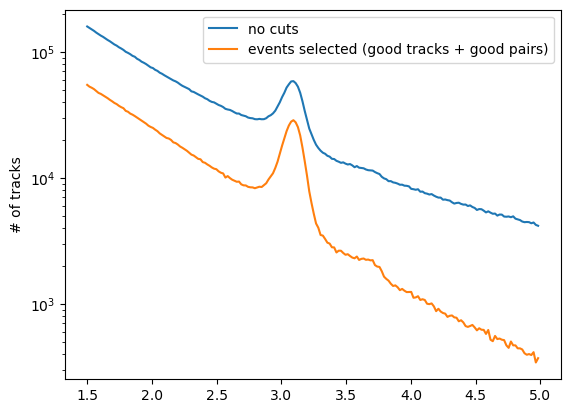

CPU times: user 916 ms, sys: 24.3 ms, total: 940 ms
Wall time: 967 ms


In [38]:
%%time
plt.plot(x_data, y_data_raw, label="no cuts") #Aucune selection
plt.plot(x_data, y_data, label="events selected (good tracks + good pairs)")
#plt.plot(x_data,y_data_model) #Modèle avec les valeurs adéquates pour le fit CB2 MC et le fit background sur une portion des valeurs exp
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.show()

In [32]:
#Fit de la fonction CB2+background avec les listes x_data et y_data pour obtenir mu, N_CB2 et les arguments de noise
%time


popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise, x_data, y_data, p0=[3.1 , 0.5, 1. ,  6.29517373e-07 , 4.91666545e-01 , 1.19404276e-07 , 1., 3.6, 3000.],
                                           sigma = n,
                                           bounds=([3. , 0.04 , 0., 0. , 0. , 0. , 0., 3.4, 0.],[3.2 , 1. , np.inf, 1. , 1. , 1. , np.inf, 4.0, np.inf]))

#popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise, x_data, y_data, p0=[3.10031936e+00, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,1.70816520e+02,
#                    7.18998714e-07,4.91666679e-01,1.36376755e-07,1.57858391e+03])
print(popt_CB2wNoise,pcov_CB2wNoise)
#mu_fitCB2wNoise,sigma_fitCB2wNoise,N_fitCB2wNoise,mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise= popt_CB2wNoise
mu_fitCB2wNoise, sigma_fitCB2wNoise, N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise, mu_fitCB2wNoise_Psi,N_fitCB2wNoise_Psi= popt_CB2wNoise
var_E=pcov_CB2wNoise[0,0]
print('Variance de la masse du JPsi :',var_E)
#y_data_fitCB2wNoise=CB2withNoise(x_data,mu_fitCB2wNoise,sigma_fitCB2wNoise,N_fitCB2wNoise,mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)
y_data_fitCB2wNoise=CB2withNoise(x_data,mu_fitCB2wNoise, sigma_fitCB2wNoise, N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise, mu_fitCB2wNoise_Psi, N_fitCB2wNoise_Psi)

var_mu=pcov_CB2wNoise[0,0]
var_sigma = pcov_CB2wNoise[1,1]
var_N = pcov_CB2wNoise[2,2]

y_data_model = CB2withNoise(x_data,3.10031936e+00, 7.59813253e-02, 1.70816520e+02, 6.29517373e-07, 4.91666545e-01, 1.19404276e-07, 1.57858391e+03,mu_fitCB2wNoise_Psi, N_fitCB2wNoise_Psi)
y_CB2_fit = CrystalBall2(x_data,mu_fitCB2wNoise, sigma_fitCB2wNoise,-5.01856715e+00,  1.54297903e+00, 1.76522134e+00,  2.82847552e+00 ,N_fitCB2wNoise)
y_CB2_fit_Psi = CrystalBall2(x_data,mu_fitCB2wNoise_Psi,7.77984483e-02 , -3.22788197e+00, 2.37452148e+00, 1.82471094e+00, 1.31670260e+00,N_fitCB2wNoise_Psi)


y_CB2_fit_2=[]
y_CB2_fit_2_Psi=[]
for i in x_data:
    y_CB2_fit_2.append(CrystalBall2_2(i,mu_fitCB2wNoise, sigma_fitCB2wNoise,-5.01856715e+00,  1.54297903e+00, 1.76522134e+00,  2.82847552e+00,N_fitCB2wNoise))
    y_CB2_fit_2_Psi.append(CrystalBall2_2(i,mu_fitCB2wNoise_Psi, 7.77984483e-02 , -3.22788197e+00, 2.37452148e+00, 1.82471094e+00, 1.31670260e+00,N_fitCB2wNoise_Psi))


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.54 µs
[3.00000000e+00 8.87889645e-01 2.29460749e+03 6.29219939e-03
 5.23683963e-01 7.53110724e-03 1.11908930e+03 3.40776858e+00
 5.03664823e+01] [[ 9.92258976e+00 -5.38047967e+00 -1.92918335e+04  1.23512954e+05
   1.24861463e+05  1.48445175e+05 -6.33941293e+07 -1.40311817e+00
  -1.76767089e+03]
 [-5.38047967e+00  3.41116437e+00  1.07408088e+04 -5.72977236e+04
  -5.80942998e+04 -6.88642033e+04  2.94584930e+07  6.24157530e-01
   1.63110361e+03]
 [-1.92918335e+04  1.07408088e+04  5.53566286e+07 -2.02205585e+08
  -2.08244220e+08 -2.43034263e+08  1.05110780e+11  2.40446255e+03
   1.01900017e+06]
 [ 1.23512954e+05 -5.72977236e+04 -2.02205585e+08  2.09409161e+09
   2.10696757e+09  2.51677956e+09 -1.07189813e+12 -1.67462036e+04
  -1.13918603e+07]
 [ 1.24861463e+05 -5.80942998e+04 -2.08244220e+08  2.10696757e+09
   2.12087134e+09  2.53225746e+09 -1.07882355e+12 -1.68595878e+04
  -1.14027184e+07]
 [ 1.48445175e+05 -6.88642033e+04 -2.4

No handles with labels found to put in legend.


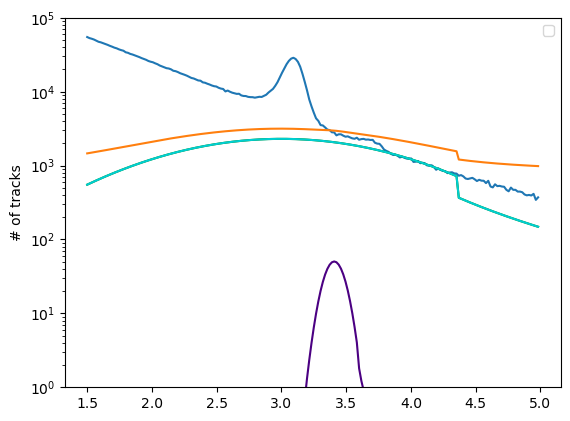

CPU times: user 1.23 s, sys: 36 ms, total: 1.27 s
Wall time: 1.32 s


In [39]:
%%time
#vhInvMass.plot(label="no cuts")
plt.plot(x_data, y_data)
#plt.scatter(x_data,y_data)
plt.plot(x_data,y_data_fitCB2wNoise)
#plt.plot(x_data,y_CB2_fit,'r')
plt.plot(x_data,y_CB2_fit_2,'g')
#plt.plot(x_data,y_data_model)
plt.plot(x_data, y_CB2_fit, color="darkturquoise")
plt.plot(x_data, y_CB2_fit_2_Psi, color="indigo")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.ylim(1,100000)
plt.show()

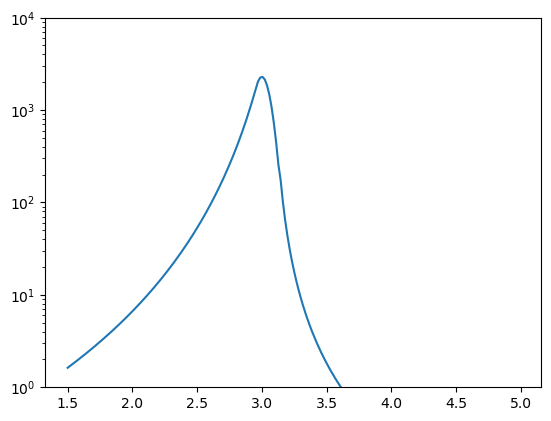

Valeur de l intégrale en utilisant la fonction quad de scipy [2.67404706e+04 3.60233441e-04]
Valeur de l intégrale en utilisant la methodes des rectagnles 26725.556458700627


In [35]:
#I = quad(integrand, 0, 1, args=(a,b))
y_data_finale=[]
for i in x_data:
    y_data_finale.append(CrystalBall2_2(i, mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))
plt.plot(x_data, y_data_finale)
plt.yscale("log")
plt.ylim(1,10000)
plt.show()
    
    
I = quad(CrystalBall2_2,1,5,
        args=(mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))
I = I/vhQualInvMassEvSel.axes[0].widths[0]

print('Valeur de l intégrale en utilisant la fonction quad de scipy',I)

integrale=0
pas=x_data[1]-x_data[0]
for i in range(0,len(x_data)):
    x=pas*i
    integrale = integrale + pas*CrystalBall2_2(x, mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise)

integrale = integrale/vhQualInvMassEvSel.axes[0].widths[0]    
print('Valeur de l intégrale en utilisant la methodes des rectagnles',integrale)
    

In [36]:
var_alpha,var_alpha1,var_n,var_n1 = 3.82025732e-04,1.74935625e-02,2.11990082e-01,1.42526094e-01

# définir le point où l'on veut calculer la dérivée partielle
point = [mu_fitCB2wNoise, sigma_fitCB2wNoise,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise]

# définir la précision pour les calculs numériques
eps = 1e-10

# calculer la dérivée partielle par rapport à mu
d_mu = (CrystalBall2(x_data,point[0] + eps, point[1], point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_mu = var_mu * d_mu

# calculer la dérivée partielle par rapport à sigma
d_sigma = (CrystalBall2(x_data,point[0], point[1] + eps, point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_sigma = var_sigma*d_sigma

# calculer la dérivée partielle par rapport à alpha
d_alpha = (CrystalBall2(x_data,point[0], point[1], point[2] + eps, point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_alpha = np.abs(var_alpha*d_alpha)
d_alpha1 = (CrystalBall2(x_data,point[0], point[1], point[2], point[3]+eps, point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_alpha1 = np.abs(var_alpha1*d_alpha1)
d_n = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4]+eps, point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_n = np.abs(var_n*d_n)
d_n1 = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5]+eps, point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_n1 = np.abs(var_n1*d_n1)
d_N = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6]+eps) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_N = np.abs(var_N*d_N)

# liste des listes des dérivées
#d_list=[d_mu, d_sigma, d_alpha, d_alpha1, d_n, d_n1]
d_list_stat=[d_mu, d_sigma, d_N]
d_list_syst=[d_alpha, d_alpha1, d_n, d_n1]

pas=x_data[1]-x_data[0]
integrale_list_stat = []
integrale_list_syst = []
for i in range(0,len(d_list_stat)):
    a=0
    for j in d_list_stat[i]:
        a = a + j*pas
    integrale_list_stat.append(a/vhQualInvMassEvSel.axes[0].widths[0])
print(integrale_list_stat)

pas=x_data[1]-x_data[0]
integrale_list = []
for i in range(0,len(d_list_syst)):
    a=0
    for j in d_list_syst[i]:
        a = a + j*pas
    integrale_list_syst.append(a/vhQualInvMassEvSel.axes[0].widths[0])
print(integrale_list_syst)

uncertainty_stat_NJPsi = sum(integrale_list_stat)
uncertainty_syst_NJPsi = sum(integrale_list_syst)
print("Incertitude statistique sur le nombre de J/Psi :", uncertainty_stat_NJPsi)
print("Incertitude systématique sur le nombre de J/Psi :", uncertainty_syst_NJPsi)

[418381.899858353, 702308.6450083419, 6844001291.016206]
[10.954875927010157, 0.0, 42.13655980337815, 0.0]
Incertitude statistique sur le nombre de J/Psi : 6845121981.561072
Incertitude systématique sur le nombre de J/Psi : 53.091435730388305


In [27]:
print(uncertainty_stat_NJPsi/integrale)

256126.45305024553
